# 5. Model Explainability

This notebook provides model interpretability using built-in feature importance (alternative to SHAP due to torch compatibility issues).

In [4]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.evaluation import load_model
from src.models.data_prep import prepare_model_data
from src.visualization.model_viz import plot_feature_importance

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Load Model and Data

In [5]:
# Load the best model
model = load_model("best_fraud_model")

# Load and prepare data (same as training)
df = pd.read_csv('../data/processed/fraud_featured.csv')

print(f"Loaded data shape: {df.shape}")

# Define target and columns to exclude
target = 'class'
drop_cols = [
    'user_id', 'signup_time', 'purchase_time', 'device_id',
    'ip_address', 'country', 'ip_int',
    'lower_bound_ip_address', 'upper_bound_ip_address'
]

# Encode categorical columns
categorical_cols = ['source', 'browser', 'sex', 'time_of_day']
available_cats = [c for c in categorical_cols if c in df.columns]
print(f"Encoding categorical columns: {available_cats}")

df = pd.get_dummies(df, columns=available_cats, drop_first=True)
print(f"Shape after encoding: {df.shape}")

# Handle missing values
nan_counts = df.isna().sum()
if nan_counts.sum() > 0:
    print(f"\nFilling {nan_counts.sum()} missing values...")
    df.fillna(0, inplace=True)

# Prepare data
X_train, X_test, y_train, y_test = prepare_model_data(
    df, target, exclude_cols=drop_cols, test_size=0.2
)

print(f"\nData prepared: X_test shape = {X_test.shape}")

2025-12-28 19:46:48 - fraud_detection - INFO - Loaded model from C:\Users\Lenovo\Documents\dawir\Fraud-Detection\models\best_fraud_model.joblib
Loaded data shape: (129146, 28)
Encoding categorical columns: ['source', 'browser', 'sex', 'time_of_day']
Shape after encoding: (129146, 34)

Filling 258292 missing values...
2025-12-28 19:46:48 - fraud_detection - INFO - Starting complete data preparation pipeline...
2025-12-28 19:46:48 - fraud_detection - INFO - Separating features from target 'class'...
2025-12-28 19:46:48 - fraud_detection - INFO - Features: 24 columns
2025-12-28 19:46:48 - fraud_detection - INFO - Target: class
2025-12-28 19:46:48 - fraud_detection - INFO - Total samples: 129146
2025-12-28 19:46:48 - fraud_detection - INFO - Performing stratified train-test split (test_size=0.2)...
2025-12-28 19:46:49 - fraud_detection - INFO - Training set: 103316 samples
2025-12-28 19:46:49 - fraud_detection - INFO - Test set: 25830 samples
2025-12-28 19:46:49 - fraud_detection - INFO - 

## 2. Global Feature Importance

Understanding which features are most important for fraud detection.

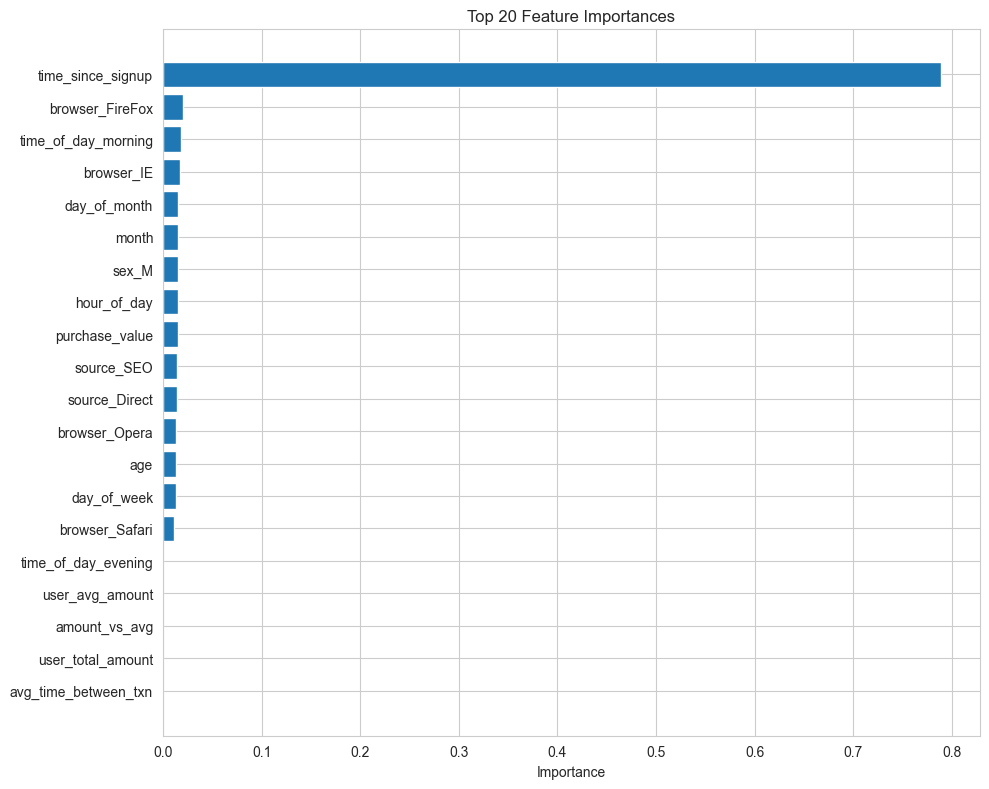

In [6]:
# Plot feature importance using the model's built-in importance
plot_feature_importance(model, X_test.columns, top_n=20)
plt.tight_layout()
plt.show()

In [7]:
# Get detailed feature importance table
if hasattr(model, 'feature_importances_'):
    importance_df = pd.DataFrame({
        'feature': X_test.columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)

    print("\nTop 20 Most Important Features:")
    print(importance_df.head(20).to_string(index=False))
else:
    print("Model does not have feature_importances_ attribute")


Top 20 Most Important Features:
             feature  importance
   time_since_signup    0.789028
     browser_FireFox    0.020704
 time_of_day_morning    0.017917
          browser_IE    0.017150
        day_of_month    0.015505
               month    0.015331
               sex_M    0.015152
         hour_of_day    0.015073
      purchase_value    0.014958
          source_SEO    0.014016
       source_Direct    0.013824
       browser_Opera    0.013700
                 age    0.013355
         day_of_week    0.013076
      browser_Safari    0.011210
 time_of_day_evening    0.000000
     user_avg_amount    0.000000
       amount_vs_avg    0.000000
   user_total_amount    0.000000
avg_time_between_txn    0.000000


## 3. Feature Correlation with Fraud

Analyzing how features correlate with fraud labels.

In [8]:
# Correlation analysis
test_data = X_test.copy()
test_data['fraud'] = y_test.values

# Calculate correlation with fraud
correlations = test_data.corr()['fraud'].sort_values(ascending=False)
print("\nTop 15 Features Correlated with Fraud:")
print(correlations.head(15))

print("\nTop 15 Features Negatively Correlated with Fraud:")
print(correlations.tail(15))


Top 15 Features Correlated with Fraud:
fraud                  1.000000
source_Direct          0.027600
sex_M                  0.014125
day_of_week            0.012389
is_weekend             0.010787
time_of_day_morning    0.004978
age                    0.004662
browser_FireFox        0.004401
browser_Opera          0.001343
hour_of_day            0.000458
browser_Safari        -0.003639
time_of_day_night     -0.004500
purchase_value        -0.004710
user_avg_amount       -0.004710
user_total_amount     -0.004710
Name: fraud, dtype: float64

Top 15 Features Negatively Correlated with Fraud:
browser_Safari         -0.003639
time_of_day_night      -0.004500
purchase_value         -0.004710
user_avg_amount        -0.004710
user_total_amount      -0.004710
time_of_day_evening    -0.004734
amount_vs_avg          -0.005843
source_SEO             -0.012790
browser_IE             -0.014792
day_of_month           -0.167626
time_since_signup      -0.263361
month                  -0.323644
time_

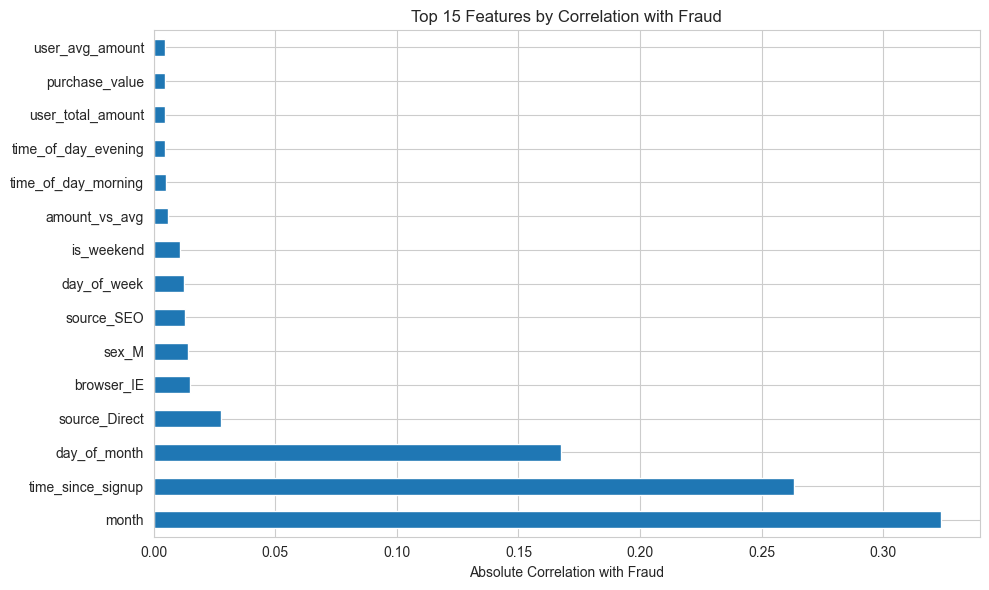

In [9]:
# Visualize top correlations
top_features = correlations.abs().sort_values(ascending=False)[1:16]  # Exclude fraud itself

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh')
plt.xlabel('Absolute Correlation with Fraud')
plt.title('Top 15 Features by Correlation with Fraud')
plt.tight_layout()
plt.show()

## 4. Local Interpretability - Sample Predictions

Examining specific fraud and non-fraud cases.

In [10]:
# Get predictions
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Find interesting cases
fraud_indices = np.where(y_test == 1)[0]
non_fraud_indices = np.where(y_test == 0)[0]

# High confidence fraud prediction
high_conf_fraud_idx = fraud_indices[np.argmax(y_pred_proba[fraud_indices])]
print("\n=== High Confidence Fraud Case ===")
print(f"Predicted probability: {y_pred_proba[high_conf_fraud_idx]:.4f}")
print(f"\nTop feature values:")
sample = X_test.iloc[high_conf_fraud_idx]
top_features_idx = importance_df.head(10)['feature'].values
for feat in top_features_idx:
    if feat in sample.index:
        print(f"  {feat}: {sample[feat]:.4f}")


=== High Confidence Fraud Case ===
Predicted probability: 0.9999

Top feature values:
  time_since_signup: 0.0003
  browser_FireFox: 0.0000
  time_of_day_morning: 0.0000
  browser_IE: 0.0000
  day_of_month: 6.0000
  month: 1.0000
  sex_M: 1.0000
  hour_of_day: 20.0000
  purchase_value: 44.0000
  source_SEO: 0.0000


In [11]:
# False positive case (predicted fraud but actually legitimate)
fp_indices = np.where((y_test == 0) & (y_pred_proba > 0.5))[0]
if len(fp_indices) > 0:
    fp_idx = fp_indices[0]
    print("\n=== False Positive Case ===")
    print(f"Predicted probability: {y_pred_proba[fp_idx]:.4f}")
    print(f"Actual label: Legitimate (0)")
    print(f"\nTop feature values:")
    sample = X_test.iloc[fp_idx]
    for feat in top_features_idx:
        if feat in sample.index:
            print(f"  {feat}: {sample[feat]:.4f}")
else:
    print("\nNo false positives found in test set")


No false positives found in test set


## 5. Conclusion

**Key Insights:**
- Feature importance reveals which attributes are most predictive of fraud
- Correlation analysis shows the direction and strength of relationships
- Sample analysis helps understand specific prediction cases

**Note:** This notebook uses built-in model interpretability instead of SHAP due to torch compatibility issues on Windows. The insights are still valuable for understanding model behavior.